In [181]:
# Disable annoying warnings in some packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import packages

# Data processing
import pandas as pd
import numpy as np
from pysqldf import SQLDF
import datetime

# Data science toolbox
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

# Model evaluation metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# Other packages
import timestring

In [63]:
# Multivariate analysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML

# Inline plots in jupyter notebook
%matplotlib inline

np.set_printoptions(suppress=True)

DISPLAY_MAX_ROWS = 20  # number of max rows to print for a DataFrame
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)

In [232]:
# Plotting library
import pylab as plt

# Plot size (in inches)
from IPython.core.pylabtools import figsize
figsize(14, 7)

In [257]:
# Useful methods
def variance_threshold_selector(data):

    #Select Model
    selector = VarianceThreshold(0) #Defaults to 0.0, e.g. only remove features with the same value in all samples

    #Fit the Model
    selector.fit(data)
    # features = selector.get_support(indices = True)  # returns an array of integers corresponding to left features
    # features = [column for column in data[features]]  # array of all nonremoved features' names
    features = data.columns.values[selector.get_support(indices = True)]
    
    #Format and Return
    selector = pd.DataFrame(selector.transform(data))
    selector.columns = features
    return selector

# Utility function to report best scores after hypertuning
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [30]:
# Read dataset
dataset = pd.read_excel('dataset/house.csv.xlsx')

In [31]:
# Convenience function to run sql on pandas dataframes
sqldf = SQLDF(globals())

In [ ]:
# Part 1: Data cleaning ############################################### #
# 
# Tedious cleaning data, unfortunatly origin of it is not clear to me   #
# thus I'll try to be as little invasive as possible                    #
# 
# General goals: Clean obvious mistakes and cast types to one type      #
# Remove zero-variance columns                                          #
# Remove rows with nans only                                            #
# Remove corelated columns                                              #
# Make simple visualizations of data                                    #
# Transform variables which are highly skewed                           #
# 
######################################################################

In [32]:
# Check what we got
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2017-02-25 00:00:00,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [15]:
dataset.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,20140521T000000,360000.0,3,2017-02-05 00:00:00,1530,1131,3,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2017-02-05 00:00:00,2310,5813,2,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2017-02-05 00:00:00,1600,2388,2,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [8]:
# What types?
dataset.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms         object
sqft_living        int64
sqft_lot           int64
floors            object
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [14]:
# I noticed there are some errors in typical decimal columns (e.g. bathrooms holding dates)
# Let's do some basing data cleaning now

unique_bathrooms = set(dataset['bathrooms'].tolist())
unique_bathrooms

{0,
 '0.5',
 '0.75',
 1,
 '1.75',
 2,
 '2.75',
 datetime.datetime(2017, 1, 5, 0, 0),
 datetime.datetime(2017, 1, 25, 0, 0),
 datetime.datetime(2017, 2, 5, 0, 0),
 datetime.datetime(2017, 2, 25, 0, 0),
 datetime.datetime(2017, 3, 5, 0, 0),
 datetime.datetime(2017, 3, 25, 0, 0),
 datetime.datetime(2017, 4, 5, 0, 0),
 datetime.datetime(2017, 4, 25, 0, 0),
 datetime.datetime(2017, 5, 5, 0, 0),
 datetime.datetime(2017, 5, 25, 0, 0),
 datetime.datetime(2017, 6, 5, 0, 0),
 datetime.datetime(2017, 6, 25, 0, 0),
 datetime.datetime(2017, 7, 5, 0, 0),
 3,
 '3.75',
 4,
 '4.75',
 5,
 '5.75',
 6,
 '6.75',
 '7.75',
 8}

In [ ]:
# There is lot of garbage in the bathrooms column, let's count those values

In [33]:
sqldf.execute("SELECT bathrooms, count(*) FROM dataset group by bathrooms;")

,bathrooms,count(*)
0,0,10
1,0.5,4
2,0.75,72
3,1,3852
4,1.75,3048
5,2,1930
6,2.75,1185
7,3,753
8,3.75,155
9,4,136


In [ ]:
# There may be some deeper meaning behind floats in number of bathrooms. Let's just remove those datetime
# TODO: investigate whether we should change datetimes to factorials or not

In [16]:
unique_floors = set(dataset['floors'].tolist())
unique_floors

{1,
 2,
 datetime.datetime(2017, 1, 5, 0, 0),
 datetime.datetime(2017, 2, 5, 0, 0),
 datetime.datetime(2017, 3, 5, 0, 0),
 3}

In [34]:
# Substitute dates with nans
dataset['bathrooms'] = dataset['bathrooms'].apply(lambda x: x if type(x) is not datetime.datetime else np.nan)
# Cast ints to floats
dataset['bathrooms'] = dataset['bathrooms'].astype('float', copy=False)

sqldf.execute("SELECT bathrooms, count(*) FROM dataset group by bathrooms;")

,bathrooms,count(*)
0,NaN,10409
1,0.00,10
2,0.50,4
3,0.75,72
4,1.00,3852
5,1.75,3048
6,2.00,1930
7,2.75,1185
8,3.00,753
9,3.75,155


In [35]:
# Substitute dates with nans
dataset['floors'] = dataset['floors'].apply(lambda x: x if type(x) is not datetime.datetime else np.nan)

sqldf.execute("SELECT floors, count(*) FROM dataset group by floors;")

,floors,count(*)
0,NaN,2079
1,1.0,10680
2,2.0,8241
3,3.0,613


In [ ]:
# Lot of 2 or more floos in the appartment
# TODO: ask data owner if this is the US real estate market

In [45]:
col_list = dataset.columns.tolist()

# Check again types
dataset.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [58]:
# Remove zero-variance variables
var_col_list = col_list[2:].copy()
var_col_list.remove('bathrooms')
var_col_list.remove('floors')  # as we've seen already, they have some variance
var_col_list  # which we're analyzing

['price',
 'bedrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [59]:
nonz_var = variance_threshold_selector(dataset[var_col_list])

In [60]:
nonz_var_cols = nonz_var.columns.tolist()
nonz_var_cols

['price',
 'bedrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [61]:
zero_var_cols = set(var_col_list) - set(nonz_var_cols)
zero_var_cols  # there are no zero-variance columns, which means we're fine

set()

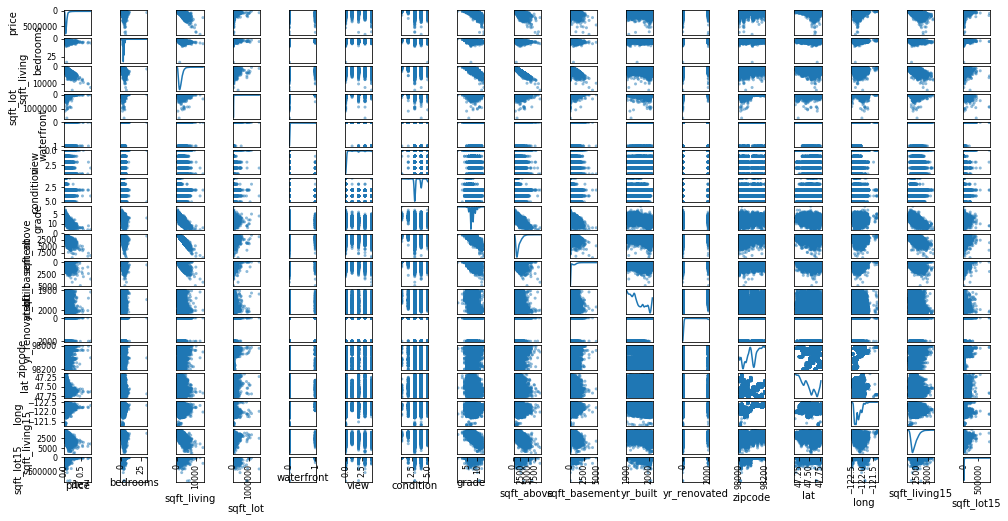

In [71]:
pd.tools.plotting.scatter_matrix(dataset[var_col_list], diagonal="kde")
plt.tight_layout()
plt.show()

In [ ]:
# In the first sights, seems like there are some perfetcly correlated variables
# Candidates: [sqft_living] and [grade], [sqft_living] and [sqft_above], [sqft_living] and [sqft_basement]
# same with [sqft_living15] instead of [sqft_living]
# Let's verify this

In [74]:
pr_cor = dataset[var_col_list].corr()
pr_cor

,price,bedrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308350,0.702035,0.089661,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.308350,1.000000,0.576671,0.031703,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
sqft_living,0.702035,0.576671,1.000000,0.172826,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,0.089661,0.031703,0.172826,1.000000,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
waterfront,0.266369,-0.006582,0.103818,0.021604,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.397293,0.079532,0.284611,0.074710,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,0.036362,0.028472,-0.058753,-0.008958,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406
grade,0.667434,0.356967,0.762704,0.113621,0.082775,0.251321,-0.144674,1.000000,0.755923,0.168392,0.446963,0.014414,-0.184862,0.114084,0.198372,0.713202,0.119248
sqft_above,0.605567,0.477600,0.876597,0.183512,0.072075,0.167649,-0.158214,0.755923,1.000000,-0.051943,0.423898,0.023285,-0.261190,-0.000816,0.343803,0.731870,0.194050
sqft_basement,0.323816,0.303093,0.435043,0.015286,0.080588,0.276947,0.174105,0.168392,-0.051943,1.000000,-0.133124,0.071323,0.074845,0.110538,-0.144765,0.200355,0.017276


In [75]:
sp_cor = dataset[var_col_list].corr(method='spearman')
sp_cor

,price,bedrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.344652,0.644191,0.074939,0.115089,0.293931,0.018490,0.658215,0.541752,0.251704,0.102038,0.101876,-0.008735,0.456409,0.063537,0.572290,0.062766
bedrooms,0.344652,1.000000,0.647366,0.216531,-0.007598,0.081421,0.012660,0.380534,0.539704,0.230496,0.180022,0.016877,-0.167186,-0.021185,0.191389,0.443816,0.201577
sqft_living,0.644191,0.647366,1.000000,0.304159,0.070326,0.232994,-0.062638,0.716400,0.843504,0.327878,0.352421,0.052679,-0.206848,0.030980,0.284584,0.746982,0.283864
sqft_lot,0.074939,0.216531,0.304159,1.000000,0.085601,0.117033,0.114724,0.152049,0.272408,0.036624,-0.037569,0.008536,-0.319494,-0.122052,0.370551,0.359572,0.922316
waterfront,0.115089,-0.007598,0.070326,0.085601,1.000000,0.284924,0.016744,0.062189,0.054490,0.051969,-0.028605,0.091649,0.029591,-0.019044,-0.038139,0.074564,0.092271
view,0.293931,0.081421,0.232994,0.117033,0.284924,1.000000,0.046000,0.217044,0.144394,0.236525,-0.066607,0.096539,0.078215,-0.000073,-0.102728,0.255793,0.116520
condition,0.018490,0.012660,-0.062638,0.114724,0.016744,0.046000,1.000000,-0.167374,-0.158126,0.161623,-0.393816,-0.066180,-0.022416,-0.022341,-0.085270,-0.086905,0.117719
grade,0.658215,0.380534,0.716400,0.152049,0.062189,0.217044,-0.167374,1.000000,0.711815,0.092927,0.500633,0.016029,-0.181552,0.103921,0.222791,0.662635,0.156109
sqft_above,0.541752,0.539704,0.843504,0.272408,0.054490,0.144394,-0.158126,0.711815,1.000000,-0.165644,0.471835,0.030942,-0.278562,-0.025860,0.385472,0.696646,0.254203
sqft_basement,0.251704,0.230496,0.327878,0.036624,0.051969,0.236525,0.161623,0.092927,-0.165644,1.000000,-0.177993,0.062837,0.114533,0.116296,-0.200191,0.129733,0.030566


In [91]:
# Find threshold of -0.75 or +0.75 (pearson)
for row in range(pr_cor.shape[0]):
    for col in range(pr_cor.shape[1]):
        # print(row, col)
        if (abs(pr_cor.iloc[row, col]) >= 0.75) and (abs(pr_cor.iloc[row, col]) < 1.0):
            location = (pr_cor.columns[col], pr_cor.index[row])
            print('Found {} pearson corr in {}'.format(pr_cor.iloc[row, col], location))

Found 0.7627044764584873 pearson corr in ('grade', 'sqft_living')
Found 0.8765965986813212 pearson corr in ('sqft_above', 'sqft_living')
Found 0.7564202590172227 pearson corr in ('sqft_living15', 'sqft_living')
Found 0.7627044764584873 pearson corr in ('sqft_living', 'grade')
Found 0.7559229376236656 pearson corr in ('sqft_above', 'grade')
Found 0.8765965986813212 pearson corr in ('sqft_living', 'sqft_above')
Found 0.7559229376236656 pearson corr in ('grade', 'sqft_above')
Found 0.7564202590172227 pearson corr in ('sqft_living', 'sqft_living15')


In [92]:
# Find threshold of -0.75 or +0.75 (spearman's)
for row in range(sp_cor.shape[0]):
    for col in range(sp_cor.shape[1]):
        # print(row, col)
        if (abs(sp_cor.iloc[row, col]) >= 0.75) and (abs(sp_cor.iloc[row, col]) < 1.0):
            location = (sp_cor.columns[col], sp_cor.index[row])
            print('Found {} spearman corr in {}'.format(sp_cor.iloc[row, col], location))

Found 0.8435037478439347 spearman corr in ('sqft_above', 'sqft_living')
Found 0.922316193937346 spearman corr in ('sqft_lot15', 'sqft_lot')
Found 0.8435037478439347 spearman corr in ('sqft_living', 'sqft_above')
Found 0.922316193937346 spearman corr in ('sqft_lot', 'sqft_lot15')


In [ ]:
# Let's try to follow the occam's razor and remove some features
# My bet is on skipping the pairs of: ('sqft_above', 'sqft_living')

# TODO: 

In [94]:
target_variable = 'price'
var_col_list.remove('price')
var_col_list.remove('sqft_living')
features = var_col_list

In [ ]:
# Part 2: Feature analysis and engineering ######
# 
# Do something with categorical and complex data
# Do component analysis or similar 
# 
#################################################

In [107]:
# Let's enginner the zip code to some more meaningful information for machine learning models
#
# vide: https://goo.gl/GYCuHT
# https://pypi.org/project/zipcode/

# It's not the Polish real estate market - zip code '98-178' (first record) don't exist in Poland
# for reference - https://kody.poczta-polska.pl/index.php
# I still believe this is US market, let's use this assumption

import zipcode

dataset['zip.state'] = dataset.apply(lambda x: zipcode.isequal(str(x['zipcode'])).state, axis=1)
dataset['zip.city'] = dataset.apply(lambda x: zipcode.isequal(str(x['zipcode'])).city, axis=1)
dataset['zip.population'] = dataset.apply(lambda x: int(zipcode.isequal(str(x['zipcode'])).population), axis=1)

# economical situation
dataset['zip.tax_returns_filed'] = dataset.apply(lambda x: int(zipcode.isequal(str(x['zipcode'])).tax_returns_filed), axis=1)
dataset['zip.wages'] = dataset.apply(lambda x: int(zipcode.isequal(str(x['zipcode'])).wages) 
                                     if zipcode.isequal(str(x['zipcode'])).wages.isdigit() else np.nan, axis=1)

# gis data
dataset['zip.lon'] = dataset.apply(lambda x: zipcode.isequal(str(x['zipcode'])).lon, axis=1)
dataset['zip.lat'] = dataset.apply(lambda x: zipcode.isequal(str(x['zipcode'])).lat, axis=1)

In [119]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zip.state,zip.city,zip.population,zip.tax_returns_filed,zip.wages,zip.lon,zip.lat,date.year,date.month,date.day
0,7129300520,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,WA,SEATTLE,18999,11449,4.301271e+08,-122.25,47.49,2014,10,13
1,6414100192,20141209T000000,538000.0,3,NaN,2570,7242,2.0,0,0,...,WA,SEATTLE,28991,18799,7.969699e+08,-122.30,47.71,2014,12,9
2,5631500400,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,WA,KENMORE,17666,10067,5.621062e+08,-122.24,47.75,2015,2,25
3,2487200875,20141209T000000,604000.0,4,3.0,1960,5000,1.0,0,0,...,WA,SEATTLE,12841,8180,4.751276e+08,-122.39,47.53,2014,12,9
4,1954400510,20150218T000000,510000.0,3,2.0,1680,8080,1.0,0,0,...,WA,SAMMAMISH,22999,11254,1.177565e+09,-122.02,47.62,2015,2,18


In [117]:
dataset['date.year'] = dataset.apply(lambda x: datetime.datetime.strptime(x['date'], '%Y%m%dT000000').year, axis=1)
dataset['date.month'] = dataset.apply(lambda x: datetime.datetime.strptime(x['date'], '%Y%m%dT000000').month, axis=1)
dataset['date.day'] = dataset.apply(lambda x: datetime.datetime.strptime(x['date'], '%Y%m%dT000000').day, axis=1)

In [132]:
# Because we have some missing data after cleaning, which makes it sparse
# let's try to use TruncatedSVD first

# columns non-compatible with svd:

data_for_ca = dataset.columns.tolist()[3:]
data_for_ca.remove('zipcode')
data_for_ca.remove('zip.city')
data_for_ca.remove('zip.state')
data_for_ca.remove('zip.wages')

imp = Imputer(verbose=True)

data_ca = imp.fit_transform(dataset[data_for_ca])

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(data_ca)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=7,
       random_state=42, tol=0.0)

In [133]:
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())  
print(svd.singular_values_)

# 5 singular values explain > 0.999 of variance

[0.76156922 0.12603171 0.11022185 0.00124697 0.00055361]
0.9996233634237804
[7652206.23857176 4322705.78602782 2478472.31888619  270601.74076351
  176246.52901619]


In [136]:
# Let's do the same with PCA
# We need to do imputing as well as scaling the features

# Standardizing the features
scal = StandardScaler()
data_scaled = scal.fit_transform(data_ca)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(data_scaled)

In [137]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())  
print(pca.singular_values_)

[0.20956984 0.11598543 0.08631208 0.07871296 0.0742224 ]
0.5648027017125907
[329.70652303 245.28153677 211.59184778 202.06274921 196.21429799]


In [204]:
# #############################################################################
# 
# Part 3: Try machine learning models which optimize OOB error (no need for CV)
#
# Train a machine learning model which relies on OOB - e.g. RandomForest
#
# #############################################################################

# Prepare test and train data

from sklearn.model_selection import train_test_split

Y = dataset['price']
x = dataset.columns.tolist()[3:]
x.remove('zipcode')
x.remove('zip.city')
x.remove('zip.state')

X = dataset[x]

# Filling in NA's
# Random forest won't accept null values
imp = Imputer()
X = imp.fit_transform(X)

# Scaling is a must for algorithms: SGDRegressor, LinearSVR, MLP
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [205]:
len(x_train), len(x_test)

(17290, 4323)

In [206]:
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.398737,-0.071295,-0.326539,-0.048575,-0.911884,-0.087173,-0.305759,0.907554,1.142667,-0.010133,...,1.113911,0.011960,1.343190,0.955472,0.834912,0.604729,-1.372919,-0.690655,-0.505394,1.310015
1,-1.473959,-1.407054,-1.175824,-0.275401,-0.911884,-0.087173,-0.305759,-0.629187,-1.409587,-1.193605,...,-1.045489,-0.284522,1.069749,1.104821,-0.045926,-0.443585,-0.095074,1.447901,-1.147400,-0.658748
2,-0.398737,-1.407054,-1.088718,-0.183994,0.000000,-0.087173,-0.305759,-0.629187,-1.409587,-0.964156,...,-1.191394,-0.181971,-0.459435,-0.457518,-1.099704,-0.998575,-0.450031,1.447901,-1.468403,1.194206
3,-0.398737,0.000000,0.010997,-0.183656,-0.911884,-0.087173,-0.305759,0.907554,-0.558836,-0.613945,...,-0.272190,-0.198452,0.557856,0.359510,-0.297645,0.049739,-1.088953,1.447901,-1.789406,-0.890367
4,-1.473959,0.000000,-0.369003,-0.329988,0.969678,-0.087173,-0.305759,-0.629187,0.291916,-0.413479,...,0.150936,-0.084768,0.925820,0.975911,1.088595,-0.011926,1.182770,1.447901,-0.826397,0.151919


In [207]:
pd.DataFrame(y_train).head()

,price
6325,325000.0
13473,257000.0
17614,228500.0
16970,288000.0
20868,479000.0


In [208]:
# Train random forest regression

regr = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
regr.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [209]:
regr.oob_score_

0.8737896575004154

In [210]:
predicted = regr.predict(x_test)

In [211]:
y_true, y_pred = y_test, predicted

print('Explained variance regression score function: {}'.format(explained_variance_score(y_true, y_pred))) 
# Best possible score is 1.0, lower values are worse.

print('Mean absolute error regression loss: {}'.format(mean_absolute_error(y_true, y_pred)))
print('Mean squared error regression loss: {}'.format(mean_squared_error(y_true, y_pred)))
print('Mean squared logarithmic error regression loss: {}'.format(mean_squared_log_error(y_true, y_pred)))
print('Median absolute error regression loss: {}'.format(median_absolute_error(y_true, y_pred)))
print('R^2 score: {}'.format(r2_score(y_true, y_pred)))

Explained variance regression score function: 0.9795364934289145
Mean absolute error regression loss: 27192.467610532807
Mean squared error regression loss: 3093617082.7812247
Mean squared logarithmic error regression loss: 0.005033941914642291
Median absolute error regression loss: 14452.0
R^2 score: 0.9795364177683331


In [252]:
# 
# Visualize predicted and true plot of appartment size vs price
# 

X_plot = x_test[:,2]
Y_plot_true_t = y_test
Y_plot_predicted_t = y_pred

X_plot_orig = scaler.inverse_transform(x_test)[:,2]

In [253]:
# scaler.inverse_transform(x_test)

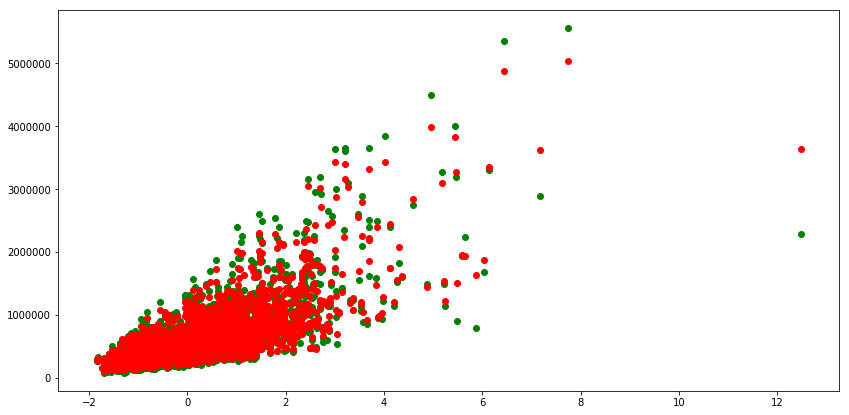

In [254]:
# Make two series plot

plt.scatter(X_plot, Y_plot_true_t, color='g')
plt.scatter(X_plot, Y_plot_predicted_t, color='r')
plt.show()

# Y axis - green is true test price, red is predicted test price
# X axis - appartment square living size (transformed)

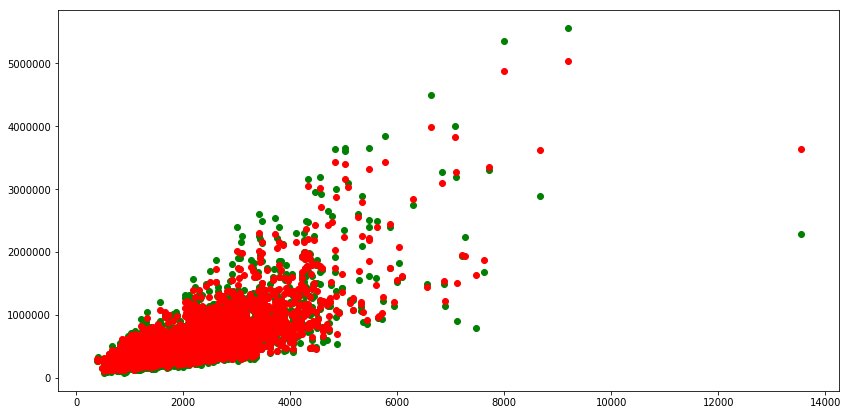

In [255]:
plt.scatter(X_plot_orig, Y_plot_true_t, color='g')
plt.scatter(X_plot_orig, Y_plot_predicted_t, color='r')
plt.show()

# Hence only values in X axis changed - StandardScaler is very reliable

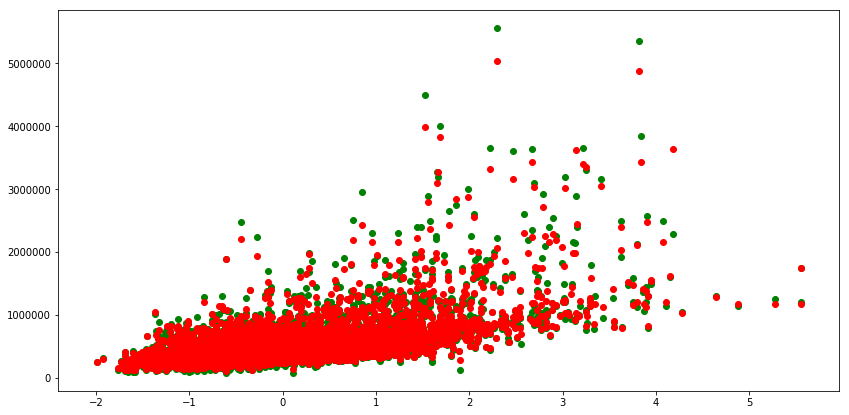

In [280]:
X_plot = x_test[:,-10]

plt.scatter(X_plot, Y_plot_true_t, color='g')
plt.scatter(X_plot, Y_plot_predicted_t, color='r')
plt.show()

# Y axis - green is true test price, red is predicted test price
# X axis - sqft_living15 (transformed)

In [ ]:
# 
# Make hyper-parameter tuning of the RandomForest regressor
# 

In [256]:
regr.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [264]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from time import time

# Using randomized search instead of grid search seems more tempting to me, lets do it!
rfr_clf = RandomForestRegressor(n_jobs=-1, oob_score=True)

param_dist = {"max_depth": [10, 20, 25, 50, None],
              "n_estimators": sp_randint(40, 120),
              "max_features": ["auto", "sqrt", "log2"],
              "min_samples_split": sp_randint(2, 12),
              "min_samples_leaf": sp_randint(1, 11),
              # "bootstrap": [True, False],
              "min_impurity_decrease": [0., 0.1, 0.05]}

# Optimizing through mse

# Run randomized search
n_iter_search = 125
random_search = RandomizedSearchCV(rfr_clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, Y)  # exactly as I did "regr.fit(X, Y)" before

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

best = random_search.best_estimator_
print('OOB score of best model: {}'.format(best.oob_score_))

report(random_search.cv_results_)

RandomizedSearchCV took 472.78 seconds for 125 candidates parameter settings.
OOB score of best model: 0.8778143204917686
Model with rank: 1
Mean validation score: 0.873 (std: 0.004)
Parameters: {'max_depth': 50, 'max_features': 'auto', 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70}

Model with rank: 2
Mean validation score: 0.873 (std: 0.007)
Parameters: {'max_depth': 25, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 45}

Model with rank: 3
Mean validation score: 0.872 (std: 0.004)
Parameters: {'max_depth': 50, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 112}



In [265]:
# Optimizing through explained variance

# Run randomized search
n_iter_search = 125
random_search = RandomizedSearchCV(rfr_clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   scoring="explained_variance")

start = time()
random_search.fit(X, Y)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

best = random_search.best_estimator_
print('OOB score of best model: {}'.format(best.oob_score_))

report(random_search.cv_results_)

RandomizedSearchCV took 414.62 seconds for 125 candidates parameter settings.
OOB score of best model: 0.8760654883655972
Model with rank: 1
Mean validation score: 0.875 (std: 0.007)
Parameters: {'max_depth': 25, 'max_features': 'sqrt', 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 68}

Model with rank: 2
Mean validation score: 0.874 (std: 0.008)
Parameters: {'max_depth': 25, 'max_features': 'sqrt', 'min_impurity_decrease': 0.05, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 86}

Model with rank: 3
Mean validation score: 0.873 (std: 0.004)
Parameters: {'max_depth': 25, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 95}



In [212]:
# #############################################################################
# 
# Part 4: Compare couple of machine learning models and choose best
# 
# Use cross-validation to find a robust and accurate model between many
# 
# #############################################################################

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import ExtraTreesRegressor

In [225]:
# prepare models
models = []

# hyper-parameter tuning will be done later
models.append(('LR', LinearRegression()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('SGD', SGDRegressor()))
models.append(('ETR', ExtraTreesRegressor()))
# models.append(('MLP', MLPRegressor(max_iter=400))) # avoid ConvergenceWarning by making this higher
# models.append(('SVR', LinearSVR()))
# models.append(('ISO', IsotonicRegression()))
# models.append(('PAR', PassiveAggressiveRegressor()))
# seems like IsotonicRegression takes a 1d in X, so I don't use it

# evaluate each model in turn
results = []
names = []
scoring = 'explained_variance'  # 'mean_squared_error'

seed = 42

In [226]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.728521 (0.009252)
GBR: 0.872786 (0.014777)
RFR: 0.861903 (0.015595)
SGD: 0.724948 (0.010776)
ETR: 0.868295 (0.021373)


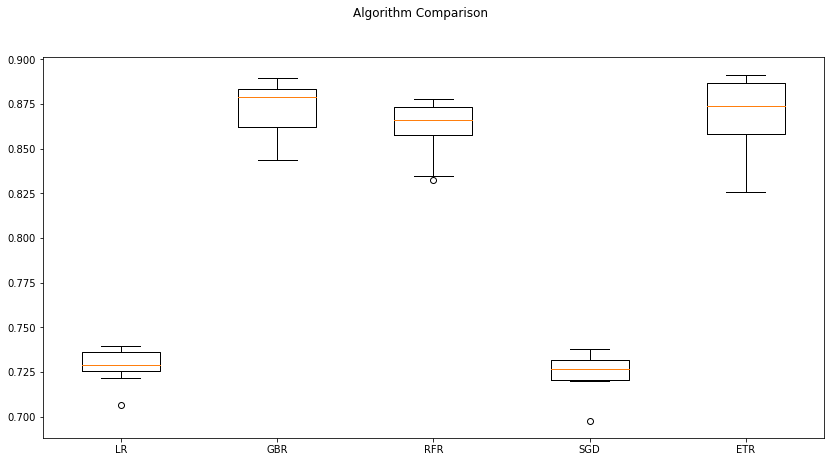

In [227]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [230]:
scoring = 'r2'

results.clear()
names.clear()

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.727728 (0.009377)
GBR: 0.872786 (0.014873)
RFR: 0.867521 (0.019819)
SGD: 0.722431 (0.010966)
ETR: 0.866616 (0.021944)


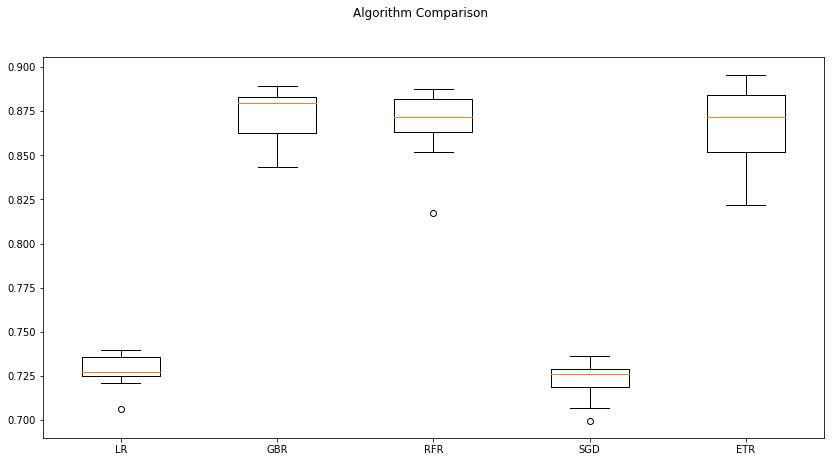

In [231]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [283]:
models

[('LR',
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)),
 ('GBR',
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=100, presort='auto', random_state=None,
               subsample=1.0, verbose=0, warm_start=False)),
 ('RFR', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0, warm_start=False)),
 ('SGD', SGDRegressor(alpha

In [285]:
# Let's try to hypertune GradientBoostingRegressor

models[1][1].get_params()

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [287]:
gbr_clf = GradientBoostingRegressor()

param_dist = {"loss": ['ls', 'lad', 'huber', 'quantile'],
              "n_estimators": sp_randint(100, 450),
              "max_depth": sp_randint(1, 10),
              "min_samples_split": sp_randint(2, 10),
              "min_samples_leaf": sp_randint(1, 6),
              "learning_rate": [0.1, 0.05, 0.15, 0.2],
              "subsample": [1.0, 0.9, 0.8],
              "min_impurity_decrease": [0., 0.1, 0.05, 0.15]}

# Optimizing through mse

# Run randomized search
n_iter_search = 125
random_search = RandomizedSearchCV(gbr_clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, Y)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

# Apologies for warnings below, it took 1h and I know already enough

RandomizedSearchCV took 3321.38 seconds for 125 candidates parameter settings.


AttributeError: 'GradientBoostingRegressor' object has no attribute 'oob_score_'

In [290]:
best = random_search.best_estimator_

print('Feature importance of best model: {}'.format(best.feature_importances_))

report(random_search.cv_results_)

Feature importance of best model: [0.01689567 0.01776109 0.08307136 0.07938172 0.00963905 0.0053949
 0.0149057  0.01653457 0.04181222 0.06873781 0.04307867 0.07200855
 0.01442651 0.10949456 0.08221849 0.07162777 0.06067789 0.02233294
 0.02262116 0.03728817 0.01702624 0.02347775 0.00711331 0.02521415
 0.03725973]
Model with rank: 1
Mean validation score: 0.902 (std: 0.002)
Parameters: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 6, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 373, 'subsample': 0.8}

Model with rank: 2
Mean validation score: 0.899 (std: 0.005)
Parameters: {'learning_rate': 0.15, 'loss': 'huber', 'max_depth': 7, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 371, 'subsample': 0.9}

Model with rank: 3
Mean validation score: 0.899 (std: 0.004)
Parameters: {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 5, 'min_sampl

In [291]:
# Just one more time

gbr_clf = GradientBoostingRegressor()

param_dist = {"loss": ['huber'],
              "alpha": [0.9, 0.95, 0.85],
              "n_estimators": sp_randint(300, 500),
              "max_depth": sp_randint(5, 8),
              "min_samples_split": sp_randint(2, 10),
              "min_samples_leaf": sp_randint(2, 6),
              "learning_rate": [0.1, 0.05, 0.15],
              "subsample": [1.0, 0.9, 0.8],
              "min_impurity_decrease": [0., 0.1, 0.05]}

# Optimizing through mse

# Run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(gbr_clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, Y)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

best = random_search.best_estimator_

report(random_search.cv_results_)

# Seems like 0.904 is the max

RandomizedSearchCV took 5902.27 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.904 (std: 0.002)
Parameters: {'alpha': 0.9, 'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 7, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 480, 'subsample': 0.8}

Model with rank: 2
Mean validation score: 0.904 (std: 0.005)
Parameters: {'alpha': 0.95, 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 6, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 348, 'subsample': 0.9}

Model with rank: 3
Mean validation score: 0.904 (std: 0.003)
Parameters: {'alpha': 0.9, 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 6, 'min_impurity_decrease': 0.05, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 398, 'subsample': 0.9}



In [295]:
# Predict again on test data, but use the hypertuned model
print('Test data\n')

predicted = best.predict(x_test)

y_true, y_pred = y_test, predicted

print('Explained variance regression score function: {}'.format(explained_variance_score(y_true, y_pred))) 
# Best possible score is 1.0, lower values are worse.

print('Mean absolute error regression loss: {}'.format(mean_absolute_error(y_true, y_pred)))
print('Mean squared error regression loss: {}'.format(mean_squared_error(y_true, y_pred)))
print('Mean squared logarithmic error regression loss: {}'.format(mean_squared_log_error(y_true, y_pred)))
print('Median absolute error regression loss: {}'.format(median_absolute_error(y_true, y_pred)))
print('R^2 score: {}'.format(r2_score(y_true, y_pred)))

# This time, calculate on all data
print('\nAll data\n')

predicted = best.predict(X)

y_true, y_pred = Y, predicted

print('Explained variance regression score function: {}'.format(explained_variance_score(y_true, y_pred))) 
# Best possible score is 1.0, lower values are worse.

print('Mean absolute error regression loss: {}'.format(mean_absolute_error(y_true, y_pred)))
print('Mean squared error regression loss: {}'.format(mean_squared_error(y_true, y_pred)))
print('Mean squared logarithmic error regression loss: {}'.format(mean_squared_log_error(y_true, y_pred)))
print('Median absolute error regression loss: {}'.format(median_absolute_error(y_true, y_pred)))
print('R^2 score: {}'.format(r2_score(y_true, y_pred)))

Test data

Explained variance regression score function: 0.9776351489423579
Mean absolute error regression loss: 35286.23482733549
Mean squared error regression loss: 3389594003.503442
Mean squared logarithmic error regression loss: 0.011100545498889046
Median absolute error regression loss: 23371.22727453534
R^2 score: 0.9775785969088655

All data

Explained variance regression score function: 0.9749220346239946
Mean absolute error regression loss: 35451.67635626812
Mean squared error regression loss: 3385318072.6980085
Mean squared logarithmic error regression loss: 0.011959551273331611
Median absolute error regression loss: 23568.677743279666
R^2 score: 0.974881918885673


In [294]:
# Conclusions: 

# It's possible to build a model which predicts real estate price with 90% MSE accuracy
# Best algorithm of machine learning is the Gradient Boosting
# It's possible to hyper tune it and get a ~10% better score
# Model is robust, which was proved by cross validation and running on a bigger test sample
# Dataset needs some fixed preprocessing though
# We may play around more with feature engineering thanks to information on date and zip code
# It's not obvious which score function to choose, although Mean squared error (Friedman's for ensembles) should be enough
# There may be a slight risk of overfitting, but I'd need more data to verify this

# Oskar Jarczyk (oskar.jarczyk@pja.edu.pl)